<a href="https://colab.research.google.com/github/sdanesh24/COGS-150/blob/main/Minimal_Pairs_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COGS 150 Final Project

## Does GPT-2 understand literal and idiomatic sentences?

Safa Danesh
3/20/24

In [ ]:
# Importing packages

%pip install transformers
import transformers
import torch

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from scipy.spatial.distance import cosine

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
# Loading the tokenzier

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("gpt2")

In [ ]:
# Loading GPT-2

gpt2 = transformers.AutoModelForCausalLM.from_pretrained("gpt2")
gpt2.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
# Defining a function from Lab 2 to estimate the probability of a masked word

def next_seq_prob(model, tokenizer, seen, unseen):
    """Get p(unseen | seen)

    Parameters
    ----------
    model : transformers.PreTrainedModel
        Model to use for predicting tokens
    tokenizer : transformers.PreTrainedTokenizer
        Tokenizer for Model
    seen : str
        Input sequence
    unseen: str
        The sequence for which to calculate a probability
    """
    # Get ids for tokens
    input_ids = tokenizer.encode(seen, return_tensors="pt")
    unseen_ids = tokenizer.encode(unseen)

    # Loop through unseen tokens & store log probs
    log_probs = []
    for unseen_id in unseen_ids:

        # Run model on input
        with torch.no_grad():
            logits = model(input_ids).logits

        # Get next token prediction logits
        next_token_logits = logits[0, -1]
        next_token_probs = torch.softmax(next_token_logits, 0) # Normalize

        # Get probability for relevant token in unseen string & store
        prob = next_token_probs[unseen_id]
        log_probs.append(torch.log(prob))

        # Add input tokens incrementally to input
        input_ids = torch.cat((input_ids, torch.tensor([[unseen_id]])), 1)

    # Add log probs together to get total log probability of sequence
    total_log_prob = sum(log_probs)
    # Exponentiate to return to probabilities
    total_prob = torch.exp(total_log_prob)
    return total_prob.item()

In [ ]:
# Defining surprisal

def surprisal(p):
  return -np.log2(p)

## Stimuli Design

For this project, stimuli were designed to measure a difference in surprisal based on the target word of each sentence. For each of the ten selected idioms, two minimal pairs are being taken into the model. One set of minimal pairs is for the idiomatic interpretation of the sentences that include the idiomatic completion of the sentences ('MP Idiom Correct') and the other sentences that include the incorrect idiomatic completion ('MP Idiom Incorrect).

The second set of minimal pairs is for the literal interpretation of the sentences that include the literal completion of the sentences ('MP Literal Correct') and the other sentences that include the incorrect literal completion ('MP Literal Incorrect).

A sentence of context is provided before both the idiomatic and literal interpretations of the idiom to help the model more accurately calculate the surprisal of the target word. The literal and idiomatic minimal pairs were designed to be as close in length and detail to focus the model on calculating the surprisal of only the target word.

Here is the list of idioms I chose to explore:
1. She spilled the beans
2. He was always adding fuel to the fire
3. She had a hard time facing the music
4. She was beating around the bush
5. He has a chip on his shoulder
6. He bit his tongue
7. She had an ace up her sleeve
8. He jumped the gun
9. She was pulling his leg
10. He bit off more than he could chew


In [ ]:
# Creating a list of stimuli

stimuli = [
    ### sentences, target word, type of minimal pair

    ('She wasn’t very good at keeping secrets. She spilled the beans on the', ' gossip', 'MP Idiom Correct'),
    ('She wasn’t very good at keeping secrets. She spilled the beans on the', ' table', 'MP Idiom Incorrect'),
    ('She was known for being clumsy. She spilled the beans on the', ' table', 'MP Literal Correct'),
    ('She was known for being clumsy. She spilled the beans on the', ' gossip', 'MP Literal Incorrect'),

    ('He just could not let things go. He was always adding fuel to the fire during', ' arguments', 'MP Idiom Correct'),
    ('He just could not let things go. He was always adding fuel to the fire during', ' cookouts', 'MP Idiom Incorrect'),
    ('He was a daredevil. He was always adding fuel to the fire during', ' cookouts', 'MP Literal Correct'),
    ('He was a daredevil. He was always adding fuel to the fire during', ' arguments', 'MP Literal Incorrect'),

    ('She was upset her project failed. She had a hard time facing the music for her', ' career', 'MP Idiom Correct'),
    ('She was upset her project failed. She had a hard time facing the music for her', ' solo', 'MP Idiom Incorrect'),
    ('She was nervous about her performance. She had a hard time facing the music for her', ' solo', 'MP Literal Correct'),
    ('She was nervous about her performance. She had a hard time facing the music for her', ' career', 'MP Literal Incorrect'),

    ('She scheduled a meeting with her boss. She was beating around the bush to be', ' polite', 'MP Idiom Correct'),
    ('She scheduled a meeting with her boss. She was beating around the bush to be', ' found', 'MP Idiom Incorrect'),
    ('She was lost in the forest. She was beating around the bush to be', ' found', 'MP Literal Correct'),
    ('She was lost in the forest. She was beating around the bush to be', ' polite', 'MP Literal Incorrect'),

    ('He was passed over for the promotion. He has a chip on his shoulder from the', ' decision', 'MP Idiom Correct'),
    ('He was passed over for the promotion. He has a chip on his shoulder from the', ' firewood', 'MP Idiom Incorrect'),
    ('He was carrying lumber. He has a chip on his shoulder from the', ' firewood', 'MP Literal Correct'),
    ('He was carrying lumber. He has a chip on his shoulder from the', ' decision', 'MP Literal Incorrect'),

    ('His company was making a controversial decision. He bit his tongue at the', ' meeting', 'MP Idiom Correct'),
    ('His company was making a controversial decision. He bit his tongue at the', ' restaurant', 'MP Idiom Incorrect'),
    ('He eats his food too quickly. He bit his tongue at the', ' restaurant', 'MP Literal Correct'),
    ('He eats his food too quickly. He bit his tongue at the', ' meeting', 'MP Literal Incorrect'),

    ('She always has a back-up plan. She had an ace up her sleeve during the', ' trip', 'MP Idiom Correct'),
    ('She always has a back-up plan. She had an ace up her sleeve during the', ' performance', 'MP Idiom Incorrect'),
    ('She was a magician. She had an ace up her sleeve during the', ' performance', 'MP Literal Correct'),
    ('She was a magician. She had an ace up her sleeve during the', ' trip', 'MP Literal Incorrect'),

    ('He often made hasty decisions. He jumped the gun on', ' moving', 'MP Idiom Correct'),
    ('He often made hasty decisions. He jumped the gun on', ' running', 'MP Idiom Incorrect'),
    ('He was in a track race. He jumped the gun on', ' running', 'MP Literal Correct'),
    ('He was in a track race. He jumped the gun on', ' moving', 'MP Literal Incorrect'),

    ('She liked to play pranks. She was pulling his leg at the', ' party', 'MP Idiom Correct'),
    ('She liked to play pranks. She was pulling his leg at the', ' hospital', 'MP Idiom Incorrect'),
    ('She was a physical therapist. She was pulling his leg at the', ' hospital', 'MP Literal Correct'),
    ('She was a physical therapist. She was pulling his leg at the', ' party', 'MP Literal Incorrect'),

    ('He takes on a lot of responsibilities at work. He bit off more than he could chew and almost', ' quit', 'MP Idiom Correct'),
    ('He takes on a lot of responsibilities at work. He bit off more than he could chew and almost', ' choked', 'MP Idiom Incorrect'),
    ('He was very hungry. He bit off more than he could chew and almost', ' choked', 'MP Literal Correct'),
    ('He was very hungry. He bit off more than he could chew and almost', ' quit', 'MP Literal Incorrect'),

]

## Potential Issues with Stimuli

Certain idioms were harder to transform into stimuli given their sentence structure and when they are used in real-life situations - for example 'She had a hard time facing the music for her career' isn't the best use of the idiom 'She had a hard time facing the music.' As a result, some of the sentences aren't common phrases but are technically grammatically correct in order for the minimal pairs to vary as little as possible aside from the target word.

It would have been interesting to include more than 10 different idioms, but given the time constraints of the quarter, the inclusion of more idioms could be explored in a separate project.

It is interesting to note that the masked words I formulated tended to be related to locations (ex: meeting/restaurant, trip/performance, party/hospital), which I became aware of after the entire list of stimuli was created. Specifically for the 'MP Literal Correct' sentences, there are many different locations where the described events could take place, which could lead the model to being less certain that the one specific target word I selected is the 'proper' answer.

In [ ]:
### Create a dataframe of the stimuli

df_stimuli = pd.DataFrame(stimuli, columns = ['Sentences', 'Target Word', 'Type of Minimal Pair (MP)'])
df_stimuli.head(8)

,Sentences,Target Word,Type of Minimal Pair (MP)
0,She wasn’t very good at keeping secrets. She s...,gossip,MP Idiom Correct
1,She wasn’t very good at keeping secrets. She s...,table,MP Idiom Incorrect
2,She was known for being clumsy. She spilled th...,table,MP Literal Correct
3,She was known for being clumsy. She spilled th...,gossip,MP Literal Incorrect
4,He just could not let things go. He was always...,arguments,MP Idiom Correct
5,He just could not let things go. He was always...,cookouts,MP Idiom Incorrect
6,He was a daredevil. He was always adding fuel ...,cookouts,MP Literal Correct
7,He was a daredevil. He was always adding fuel ...,arguments,MP Literal Incorrect


In [ ]:
# From Lab 2 - creating a for loop that calculates the surprisal of each target word, in context

results = []
for index, row in tqdm(df_stimuli.iterrows(), total=df_stimuli.shape[0]):

  prob = next_seq_prob(gpt2, tokenizer, row['Sentences'], row['Target Word'])

  results.append({
      'Target Word': row['Target Word'],
      'Sentences': row['Sentences'],
      'Type of Minimal Pair (MP)': row['Type of Minimal Pair (MP)'],
      'Probability': prob,
      'Surprisal': surprisal(prob)
  })

100%|██████████| 40/40 [00:12<00:00,  3.19it/s]


In [ ]:
# Creating a dataframe that includes the probability and surprisal calculations of the target word

df_results = pd.DataFrame(results)
df_results.head(8)

,Target Word,Sentences,Type of Minimal Pair (MP),Probability,Surprisal
0,gossip,She wasn’t very good at keeping secrets. She s...,MP Idiom Correct,0.000667,10.551070
1,table,She wasn’t very good at keeping secrets. She s...,MP Idiom Incorrect,0.000356,11.457047
2,table,She was known for being clumsy. She spilled th...,MP Literal Correct,0.000255,11.939052
3,gossip,She was known for being clumsy. She spilled th...,MP Literal Incorrect,0.000567,10.785133
4,arguments,He just could not let things go. He was always...,MP Idiom Correct,0.000483,11.014467
5,cookouts,He just could not let things go. He was always...,MP Idiom Incorrect,0.000001,19.400818
6,cookouts,He was a daredevil. He was always adding fuel ...,MP Literal Correct,0.000002,18.897049
7,arguments,He was a daredevil. He was always adding fuel ...,MP Literal Incorrect,0.000140,12.807254


Text(0.5, 1.0, 'Average Surprisal of Minimal Pair Types')

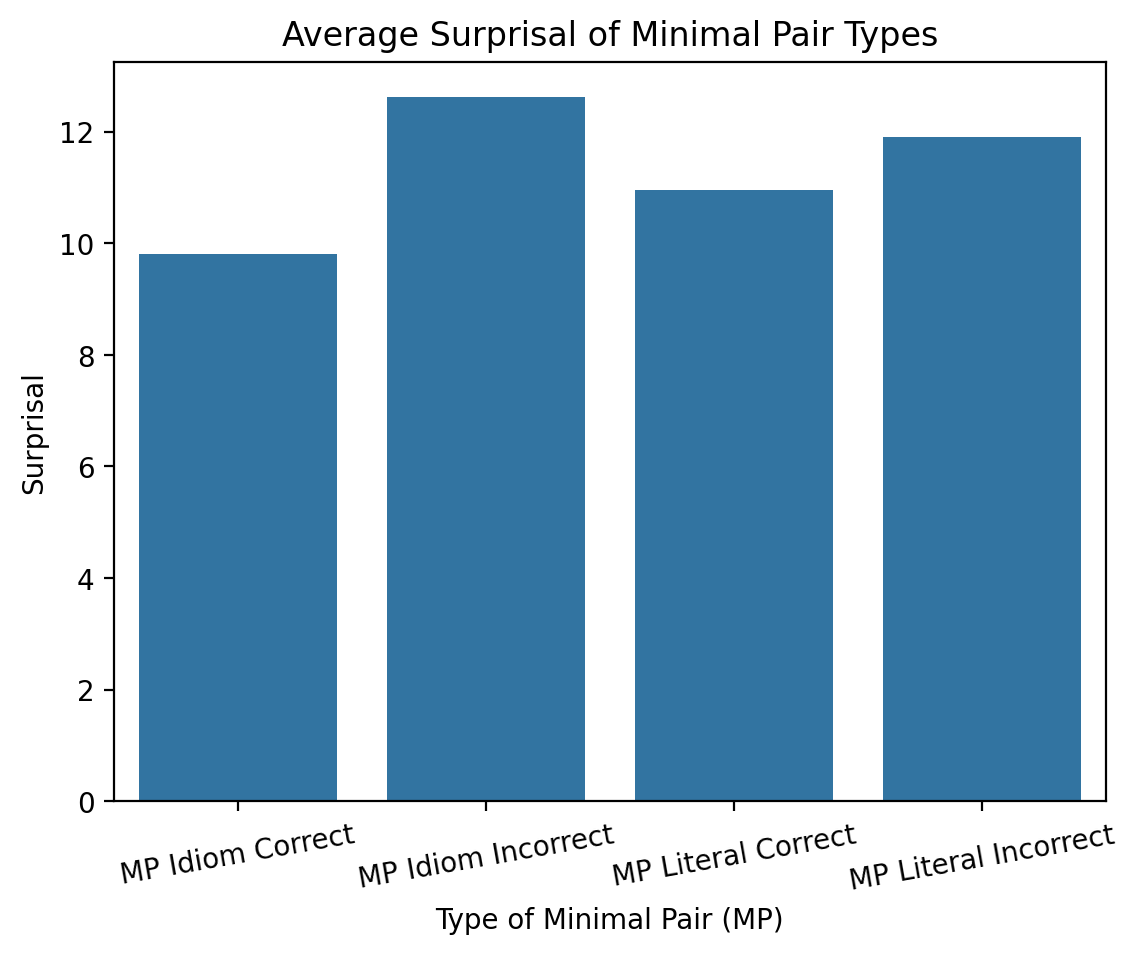

In [ ]:
# Plotting the average surprisal across each of the four minimal pair types

sns.barplot(data = df_results,
            x = "Type of Minimal Pair (MP)",
            y = "Surprisal",
            errorbar = None)
            #width = 0.5)
plt.xticks(rotation = 10)
plt.title('Average Surprisal of Minimal Pair Types')

#the higher the surprisal the less likely the model expected that word
#surprisal = inverse of probability


Text(0.5, 1.0, 'Average Surprisal of Idiomatic Minimal Pair')

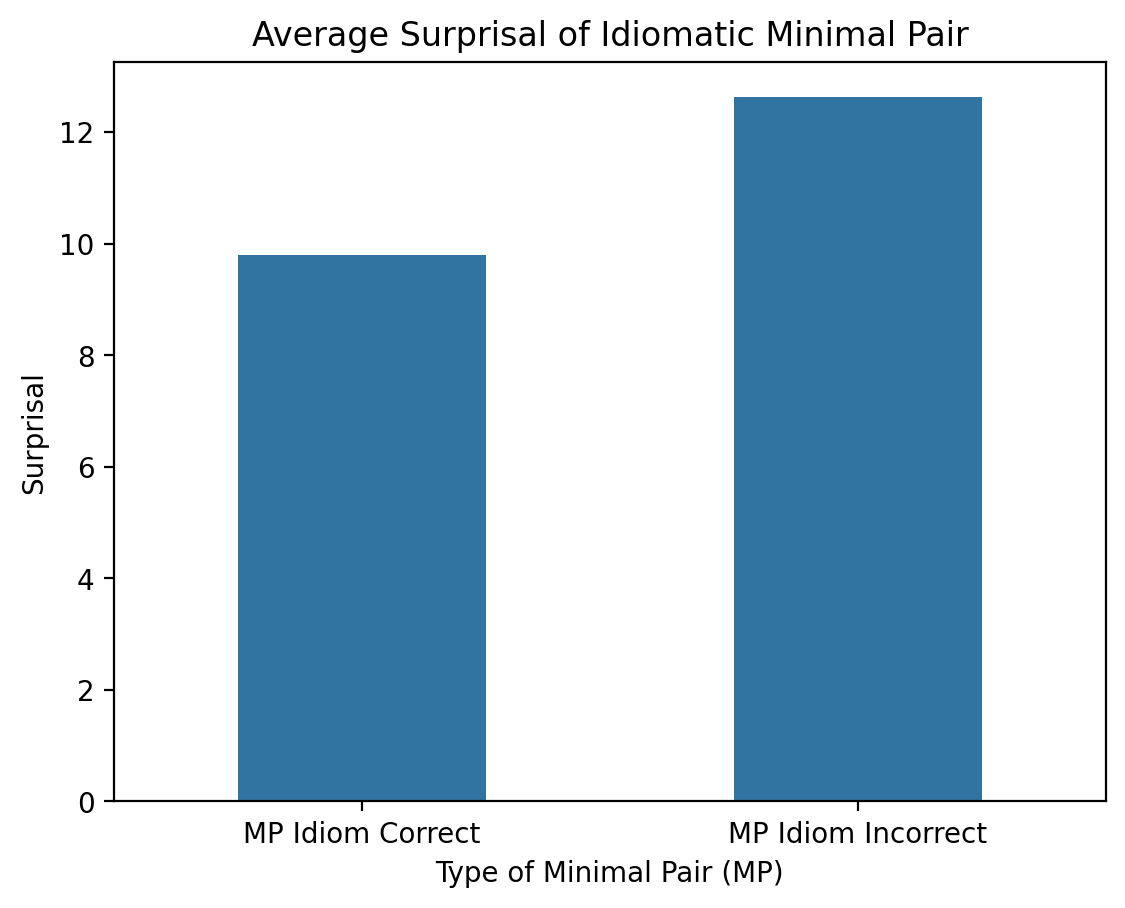

In [ ]:
# Plotting the average surprisal across the idiomatic minimal pairs

sns.barplot(data = df_results[df_results['Type of Minimal Pair (MP)'].isin(['MP Idiom Correct', 'MP Idiom Incorrect'])],
            x = "Type of Minimal Pair (MP)",
            y = "Surprisal",
            errorbar = None,
            width = 0.5)
plt.title('Average Surprisal of Idiomatic Minimal Pair')


Text(0.5, 1.0, 'Average Surprisal of Literal Minimal Pair')

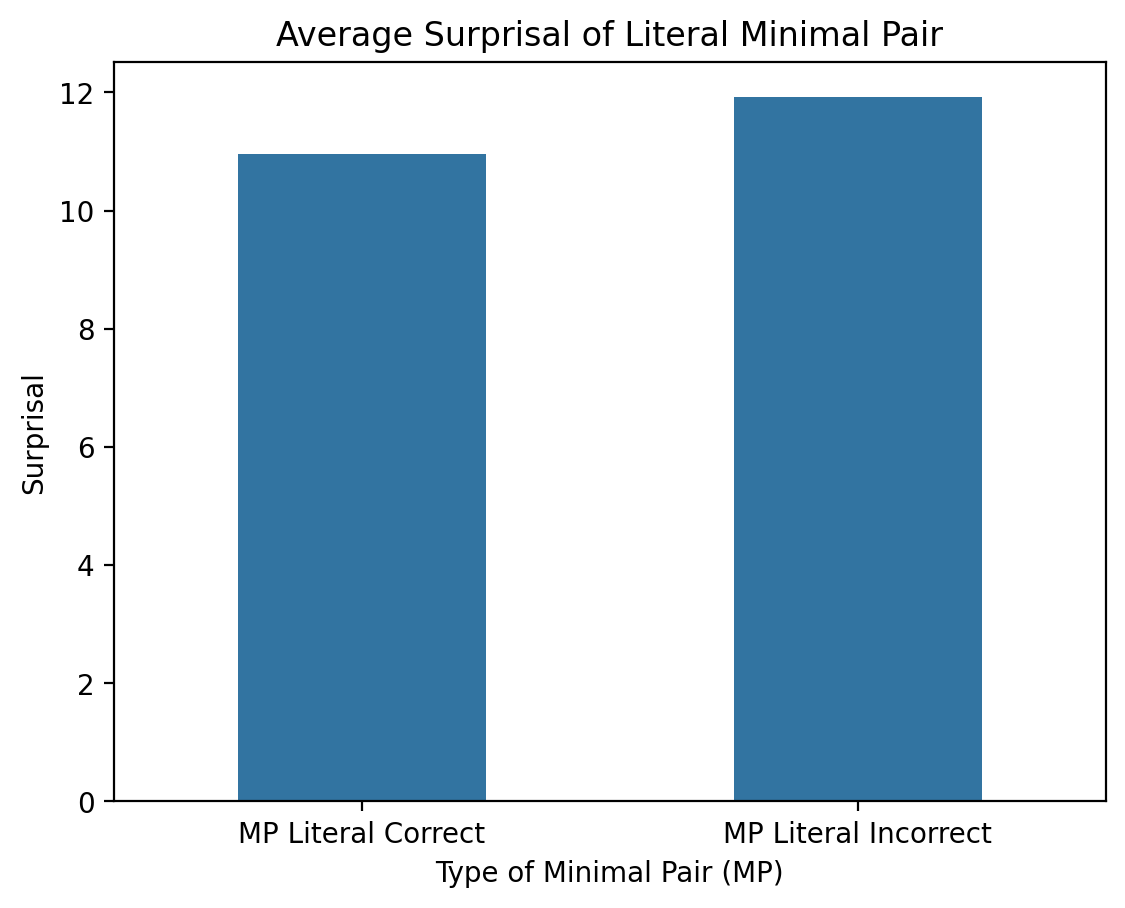

In [ ]:
# Plotting the average surprisal across the literal minimal pairs

sns.barplot(data = df_results[df_results['Type of Minimal Pair (MP)'].isin(['MP Literal Correct', 'MP Literal Incorrect'])],
            x = "Type of Minimal Pair (MP)",
            y = "Surprisal",
            errorbar = None,
            width = 0.5),
plt.title('Average Surprisal of Literal Minimal Pair')


## Discussion of Results and Implications

This project addressed whether GPT-2 can understand the difference between literal and idiomatic sentences. By calculating the surprisal of varying target words in literal and idiomatic contexts, we can see that there is a lower surprisal value for the correct completions of both literal and idiomatic sentences compared to the sentences with incorrect completions. Using this metric, it is clear that GPT-2 does understand literal and idiomatic sentences.

Moving forward with the understanding that GPT-2, and possibly other LLMs, understand idiomatic sentences can help make LLMs more accessible to a variety of users. Anyone with any level of educational background can seek help from an LLM like GPT and not have to face a steep learning curve when inputting their prompt to the model. If someone only knows how to describe a concept using idioms or colloquialisms, the model will be able to understand the underlying concept a user is describing. It is ultimately exciting to consider how LLMs’ effectiveness can increase as they become more closely integrated with people.